In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import warnings
import os

import cftime
import numpy as np
import pandas as pd
import cmocean
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 11})

In [3]:
import gfdl_utils.core as gu

In [4]:
models = {
    "CM4Xp25"  : {"historical":"odiv-231", "ssp5":"odiv-232"},
    "CM4Xp125" : {"historical":"odiv-255", "ssp5":"odiv-293"}
}

In [223]:
from common import *

surface_fluxes["fgcfc11_annual"] = surface_fluxes["fgcfc11"].groupby("time.year").mean()
surface_fluxes["fgcfc11_annual"] = surface_fluxes["fgcfc11_annual"].where(surface_fluxes["deptho"]!=0, np.nan)

always_sink = (surface_fluxes["fgcfc11_annual"] > -1e-18).rolling({"year":10}, min_periods=1).mean("year").all("year").compute()
source_year = (surface_fluxes["fgcfc11_annual"].rolling({"year":10}, min_periods=1).mean("year") <= -1e-18).idxmax("year")
source_year = source_year.where((~always_sink) & (surface_fluxes.deptho!=0))

In [55]:
data_dict = {}

for model in models.keys():
    
    inv_path = f"../data/transient_tracer_inventory_{model}-SSP585.nc"
    if os.path.exists(inv_path):
        print(f"Loading inert tracer inventories for {model}")
        data_dict[model] = xr.open_dataset(inv_path)

Loading inert tracer inventories for CM4Xp25
Loading inert tracer inventories for CM4Xp125


In [56]:
data_dict["CM4Xp125-piControl"] = xr.open_dataset("../data/transient_tracer_inventory_CM4Xp125-piControl.nc")
# align times with historical + SSP5-8.5
data_dict["CM4Xp125-piControl"] = data_dict["CM4Xp125-piControl"].assign_coords(
    {"time": data_dict["CM4Xp125"].time[0:data_dict["CM4Xp125-piControl"].time.size]}
)

In [54]:
tracer_names = ['cfc11', 'cfc12']
g_per_mol = {
    "cfc11": 137.37,
    "cfc12": 120.91,
}
Gg_per_g = 1.e-9
sec_per_year = 365.25 * 24 * 60 * 60
sec_per_nsec = 1.e-9

In [58]:
bc = xr.open_dataset("/archive/hfd/datasets/input_files/CFC_SSP585_20x20deg.20220203.nc", decode_times=False)
bc = bc.assign_coords({'Year': bc['Time'].copy() + 1601})
bc['Year'].attrs = {}
bc['Time'] = bc['Time']*365.242198781
bc['Time'].attrs['units'] = 'days since 1601-01-01 00:00:00'
bc = xr.decode_cf(bc, use_cftime=True)

In [238]:
glo = xr.open_dataset("../data/glodap_v1/glodap_cfc.nc") # CFC concentrations [pmol / kg]

# Estimate volumes of data cells
glo['dz'] = xr.ones_like(glo['depth'])
glo['dz'].data = np.diff(glo['depth_bnds'])
R = 6378.1e3 # radius of Earth in meters
glo['dA'] = R**2 * np.abs(np.sin(np.deg2rad(glo['lat']+0.5)) - np.sin(np.deg2rad(glo['lat']-0.5))) * np.deg2rad((glo['lon']+0.5) - (glo['lon']-0.5))
glo['volcello'] = glo.dz * glo.dA

mol_per_pmol = 1e-12
rho0 = 1035. # reference density [kg/m^3]
glo['CFC11_inv'] = (glo.CFC11*mol_per_pmol*rho0 * glo.volcello).sum()
glo['CFC12_inv'] = (glo.CFC12*mol_per_pmol*rho0 * glo.volcello).sum()

/vftmp/Henri.Drake/pid5324/ipykernel_20342/111864909.py:7: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pc = ax.pcolor(
/vftmp/Henri.Drake/pid5324/ipykernel_20342/111864909.py:14: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(
/vftmp/Henri.Drake/pid5324/ipykernel_20342/111864909.py:35: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(


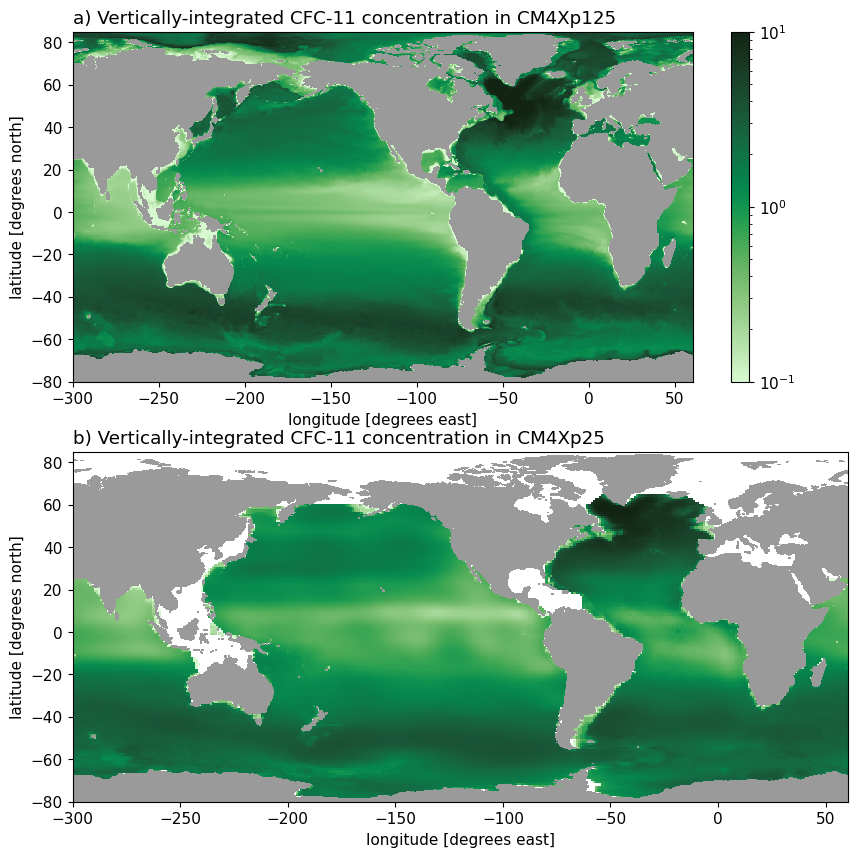

In [303]:
m2_per_km2 = 1e6

fig, axes = plt.subplots(2,1,figsize=(10, 10))

ax = axes[0]
cfc11_vint = (tracers.cfc11*tracers.thkcello*m2_per_km2).sel(year=1994).sum("zl")
pc = ax.pcolor(
    cfc11_vint.geolon,
    cfc11_vint.geolat,
    cfc11_vint,
    norm=colors.LogNorm(vmin=1e-1, vmax=10),
    cmap=cmocean.cm.algae
)
ax.pcolor(
    tracers.geolon,
    tracers.geolat,
    tracers.deptho.where(tracers.deptho==0.) + 1,
    cmap=cmocean.cm.gray,
    vmin=0, vmax=1.5
)
plt.colorbar(pc)

ax = axes[1]
cfc11_vint = (glo.CFC11*mol_per_pmol*rho0*glo.dz*m2_per_km2).sum("depth").roll(shifts={"lon":120}, roll_coords=True)
cfc11_vint = cfc11_vint.assign_coords(
    {"lon": np.mod(cfc11_vint.lon.values + 300, 360) - 300}
)
ax.pcolor(
    cfc11_vint.lon,
    cfc11_vint.lat,
    cfc11_vint,
    norm=colors.LogNorm(vmin=1e-1, vmax=10),
    cmap=cmocean.cm.algae
)
ax.pcolor(
    tracers.geolon,
    tracers.geolat,
    tracers.deptho.where(tracers.deptho==0.) + 1,
    cmap=cmocean.cm.gray,
    vmin=0, vmax=1.5
)

titles = ["a) Vertically-integrated CFC-11 concentration in CM4Xp125", "b) Vertically-integrated CFC-11 concentration in CM4Xp25", "c) Vertically-integrated CFC-11 concentration in Glodap v1 (observations)"]
for ax, title in zip(axes, titles):
    ax.set_ylim(-80, 85)
    ax.set_title(title, loc="left")
    ax.set_xlabel("longitude [degrees east]")
    ax.set_ylabel("latitude [degrees north]")

In [60]:
wang2021_path = "/work/hfd/datasets/Wang2021_MITgcm_CFCs/data/"
wang2021_CFC11 = pd.read_csv(f"{wang2021_path}MITgcm_rcp_forcing_sensitivity_inventory_CFC11.csv")
wang2021_CFC12 = pd.read_csv(f"{wang2021_path}MITgcm_rcp_forcing_sensitivity_inventory_CFC12.csv")

years = np.array(wang2021_CFC11['Year'], dtype=int)
wang2021_CFC11["Date"] = np.array([cftime.datetime(year=year, month=1, day=1) for year in years])
wang2021_CFC12["Date"] = np.array([cftime.datetime(year=year, month=1, day=1) for year in years])

mass_atm = 5.148e12            # mass of atmosphere, unit in Gg
molar_mass_air = 28.8          # average air molar mass unit in g/mol
molar_mass_CFC11 = g_per_mol["cfc11"]      # CFC11 molar mass, unit in g/mol
molar_mass_CFC12 = g_per_mol["cfc12"]      # CFC12 molar mass, unit in g/mol

ppt_to_Gg11 = (0.95*mass_atm/(molar_mass_air/molar_mass_CFC11) )*1e-12/1.07  # unit transfer from ppt to Gg
Gg_to_ppt11 = 1/ppt_to_Gg11 

ppt_to_Gg12 = (0.95*mass_atm/(molar_mass_air/molar_mass_CFC12) )*1e-12/1.07  # unit transfer from ppt to Gg
Gg_to_ppt12 = 1/ppt_to_Gg12 

In [61]:
obs_AGAGE = pd.read_csv(f"{wang2021_path}mf_CFC-11_obs.csv", header=3, skipinitialspace=True)
Time_cf = []
for t in obs_AGAGE['Time']:
    year = np.int64(np.floor(t))
    month = np.int64(np.floor((t - year)*12)+1)
    day = np.int64(np.floor((t - year - (month-1)/12)*30))
    Time_cf.append(cftime.datetime(year=year, month=month, day=day))
Time_cf = np.array(Time_cf)

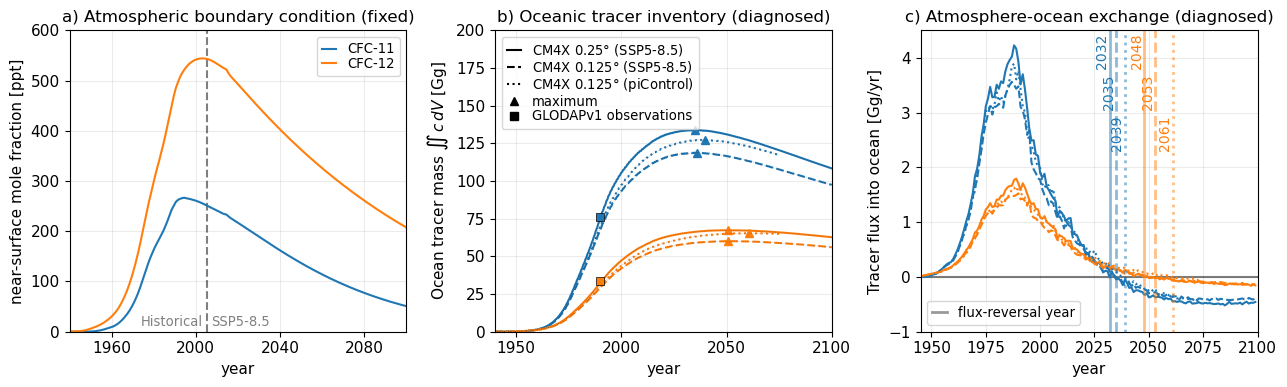

In [229]:
cols = {'cfc11':'C0', 'cfc12':'C1'}
labels = {'cfc11':'CFC11', 'cfc12':'CFC12'}
long_labels = {'cfc11':'CFC-11', 'cfc12':'CFC-12'}
long_exps = {'historical': 'Historical', 'ssp585':'SSP5-8.5'}

yscale = "linear"
ylim1 = [0., 600]
ylim2 = [0., 200]


fig = plt.figure(figsize=(13, 4))

ax = plt.subplot(1,3,1)

plt.axvline(2014, linestyle="--", color="k", alpha=0.5, linewidth=1.5)
for ((_, long_label), (tr, label)) in zip(long_labels.items(), labels.items()):
    line = bc[label].mean(['Longitude', 'Latitude']).plot(label=long_label, color=cols[tr])
    timax = bc[label].mean(['Longitude', 'Latitude']).argmax()
plt.xlim([cftime.datetime(1940, 1, 1), cftime.datetime(2100, 1, 1)])
plt.grid(True, alpha=0.25, which="major", lw=0.75)
plt.grid(True, alpha=0.15, which="minor")
plt.ylabel("near-surface mole fraction [ppt]")
plt.annotate(long_exps['historical'], xy=(0.395, 0.01), xycoords="axes fraction", ha="right", va="bottom", color="gray", fontsize=9.5)
plt.annotate(long_exps['ssp585'], xy=(0.42, 0.01), xycoords="axes fraction", ha="left", va="bottom", color="gray", fontsize=9.5)
plt.legend(labelspacing=0.06, handlelength=1.1, fontsize=9.5, loc="upper right")
plt.ylim(ylim1)
plt.yscale(yscale)
plt.xlabel("year")
plt.title("a) Atmospheric boundary condition (fixed)", fontsize=12)

ax = plt.subplot(1,3,2)
for (model, inv), ls in zip(data_dict.items(), ["-", "--", ":"]):
    for tr in tracer_names:
        line = plt.plot(
            inv['time'],
            inv[f'{tr}_volumeint'] * g_per_mol[tr] * Gg_per_g ,
            color=cols[tr], ls=ls
        )
        timax = inv[f'{tr}_volumeint'].argmax()
        plt.plot(
            inv[f'{tr}_volumeint'].isel(time=[timax])['time'],
            inv[f'{tr}_volumeint'].isel(time=[timax]) * g_per_mol[tr] * Gg_per_g ,
            '^', linewidth=0., color=line[0].get_c()
        )
        (inv[f'fg{tr}_areatimeint'] * g_per_mol[tr] * Gg_per_g ).plot(
            color="k", ls=":", alpha=0.3, lw=0.5
        )

for tr, color in zip(['cfc11', 'cfc12'], ["C0", "C1"]):
    plt.plot(
        cftime.datetime(1990, 1, 1),
        glo[f'{labels[tr]}_inv'] * g_per_mol[tr] * Gg_per_g ,
        marker="s", color=color, markeredgecolor="k", markeredgewidth=0.5
    )
plt.xlim([cftime.datetime(1940, 1, 1), cftime.datetime(2100, 1, 1)])
plt.grid(True, alpha=0.25, which="major", lw=0.75)
plt.grid(True, alpha=0.15, which="minor", lw=0.25)
plt.ylabel(r"Ocean tracer mass $ \iint\, c \, dV$ [Gg]")
plt.plot([], [], ls="-", color="k", label=r"CM4X 0.25$\degree$ (SSP5-8.5)")
plt.plot([], [], ls="--", color="k", label=r"CM4X 0.125$\degree$ (SSP5-8.5)")
plt.plot([], [], ls=":", color="k", label=r"CM4X 0.125$\degree$ (piControl)")
plt.plot([], [], "k^", label="maximum")

#plt.plot([], [], ls="-.", color="k", alpha=0.4, lw=0.5, label=r"$\int \left( \iint\,F_{c} \, dA \right) \, dt$")
plt.plot([], [], "ks", label=r"GLODAPv1 observations")
plt.legend(labelspacing=0.06, handlelength=1.1, fontsize=9.5, loc="upper left")
plt.xlabel("year")
plt.ylim(ylim2)
plt.yscale(yscale)
plt.title("b) Oceanic tracer inventory (diagnosed)", fontsize=12)

plt.subplot(1,3,3)
plt.axhline(0., color="k", lw=1.5, alpha=0.5)
for pidx, ((model, inv), ls) in enumerate(zip(data_dict.items(), ["-", "--", ":"])):
    for tr in tracer_names:
        tr_flux = inv[f'fg{tr}_areaint'].groupby("time.year").mean("time") * g_per_mol[tr] * sec_per_year * Gg_per_g
        line = tr_flux.plot(ls=ls, color=cols[tr])
        reversal_year = tr_flux['year'].isel(year=np.abs(tr_flux).where(tr_flux['year'] > 2000).argmin())
        plt.axvline(reversal_year, color=line[0].get_color(), ls=ls, alpha=0.5, lw=2)
        plt.annotate(str(reversal_year.values), (reversal_year-0.25, 4.45 -0.75*pidx), rotation="vertical", ha="right", va="top", color=line[0].get_color(), fontsize=10)

plt.plot([], [], color="k", alpha=0.4, lw=2, label="flux-reversal year")
plt.legend(labelspacing=0.06, handlelength=1.1, fontsize=9.5)
plt.xlim([1945, 2100])
plt.ylim(-1, 4.5)
plt.grid(True, alpha=0.25, which="major", lw=0.75)
plt.grid(True, alpha=0.15, which="minor", lw=0.25)
plt.ylabel("Tracer flux into ocean [Gg/yr]")
plt.title("c) Atmosphere-ocean exchange (diagnosed)", fontsize=12)

plt.tight_layout()
plt.savefig(f"../figures/CFC_boundary_boundary_conditions_and_fluxes.png", dpi=300., bbox_inches="tight")

In [63]:
# Add Wang et al. projection and observations as comparison
#plt.plot(wang2021_CFC11['Date'], wang2021_CFC11['hist_atm']*Gg_to_ppt11, linestyle="--", alpha=0.8)
#plt.plot(wang2021_CFC12['Date'], wang2021_CFC12['hist_atm']*Gg_to_ppt12, linestyle="--", alpha=0.8)
#plt.fill_between(Time_cf, obs_AGAGE['90S-30S'], obs_AGAGE['30N-90N'], facecolor="k", alpha=0.7, label="Obs (AGAGE)")

In [64]:
import doralite
sg = xr.open_dataset("/archive/Raphael.Dussin/datasets/OM4p125/mosaic_c192_om4p125_bedmachine_v20210310_hydrographyKDunne20210614_unpacked/ocean_hgrid.nc")
og = gu.open_static(doralite.dora_metadata("odiv-255")["pathPP"], "ocean_annual")

In [65]:
og = og.assign_coords({
    'geolon'  : xr.DataArray(sg['x'][1::2,1::2].data, dims=["yh", "xh"]),
    'geolat'  : xr.DataArray(sg['y'][1::2,1::2].data, dims=["yh", "xh"]),
    'geolon_u': xr.DataArray(sg['x'][1::2,0::2].data, dims=["yh", "xq"]),
    'geolat_u': xr.DataArray(sg['y'][1::2,0::2].data, dims=["yh", "xq"]),
    'geolon_v': xr.DataArray(sg['x'][0::2,1::2].data, dims=["yq", "xh"]),
    'geolat_v': xr.DataArray(sg['y'][0::2,1::2].data, dims=["yq", "xh"]),
    'geolon_c': xr.DataArray(sg['x'][0::2,0::2].data, dims=["yq", "xq"]),
    'geolat_c': xr.DataArray(sg['y'][0::2,0::2].data, dims=["yq", "xq"])
})

In [66]:
from common import *

/vftmp/Henri.Drake/pid5324/ipykernel_20342/275428033.py:54: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(
/vftmp/Henri.Drake/pid5324/ipykernel_20342/275428033.py:75: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pc = plt.pcolor(
/vftmp/Henri.Drake/pid5324/ipykernel_20342/275428033.py:82: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(pc, label="year", extend="both")
/vftmp/Henri.Drake/pid5324/ipykernel_20342/27542

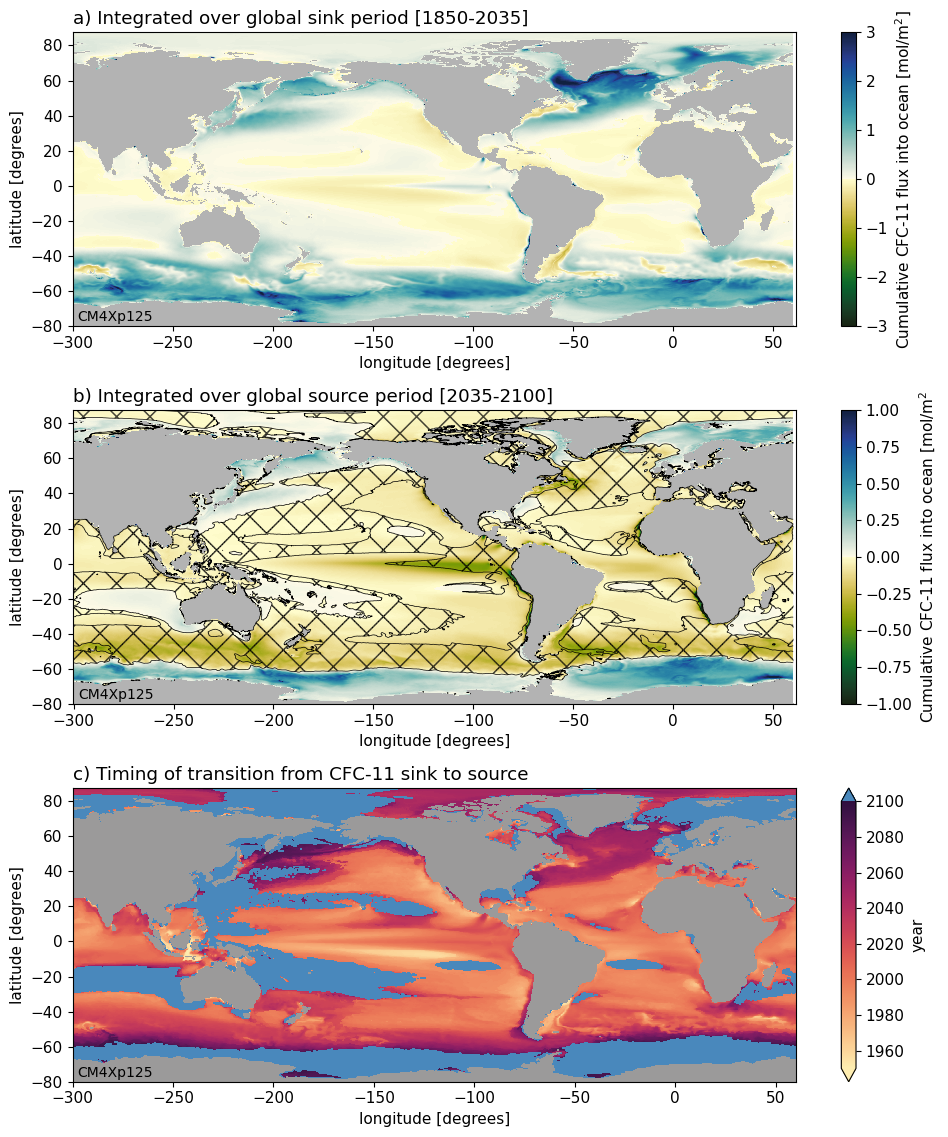

In [241]:
import cmocean
cmap = cmocean.cm.delta_r.copy()
cmap.set_bad((0.7, 0.7, 0.7))

fig, axes = plt.subplots(3,1,figsize=(10,11.5))
inv = data_dict["CM4Xp125"]

## Sink
plt.sca(axes[0])
fgcfc11_sink_plot = inv['fgcfc11_sink'].where(og.deptho.values > 0)
plt.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    fgcfc11_sink_plot*1e5,
    vmin=-3,
    vmax=3,
    cmap=cmap
)
plt.colorbar(label=r"Cumulative CFC-11 flux into ocean [mol/m$^{2}$]")
plt.xlabel("longitude [degrees]")
plt.ylabel("latitude [degrees]")
plt.title("a) Integrated over global sink period [1850-2035]", loc="left")
plt.annotate(
    "CM4Xp125", (-297.5, -79), rotation="horizontal",
    ha="left", va="bottom", color="k", fontsize=10
)
plt.ylim(-80, 87.5)

## Source
plt.sca(axes[1])
fgcfc11_source_plot = inv['fgcfc11_source'].where(og.deptho.values > 0)
plt.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    fgcfc11_source_plot*1e5,
    vmin=-1,
    vmax=1,
    cmap=cmap
)
plt.colorbar(label=r"Cumulative CFC-11 flux into ocean [mol/m$^{2}$")

sink_to_source = (inv['fgcfc11_sink'] > 0) & (inv['fgcfc11_source'] < 0)
plt.contour(
    og.geolon,
    og.geolat,
    sink_to_source,
    levels=[0.5], linestyles="solid", colors="k", linewidths=0.5
)
fgcfc11_source_plot_masked = np.ma.masked_array(
    fgcfc11_source_plot,
    mask=np.logical_not(sink_to_source)
)
N = 8
plt.pcolor(
    og.geolon[N//2::N,N//2::N],
    og.geolat[N//2::N,N//2::N],
    fgcfc11_source_plot_masked[N//2::N,N//2::N],
    hatch='X',
    alpha=0.
)

plt.xlabel("longitude [degrees]")
plt.ylabel("latitude [degrees]")
plt.title("b) Integrated over global source period [2035-2100]", loc="left")
plt.ylim(-80, 87.5)
plt.annotate(
    "CM4Xp125", (-297.5, -79), rotation="horizontal",
    ha="left", va="bottom", color="k", fontsize=10
)

plt.sca(axes[2])
cmap = cmocean.cm.matter.copy()
color_pick = 0.55
cmap.set_extremes(over=cmocean.cm.ice(color_pick))
pc = plt.pcolor(
    source_year.geolon,
    source_year.geolat,
    source_year,
    cmap=cmap,
    vmin=1950, vmax=2100,
)
plt.colorbar(pc, label="year", extend="both")
plt.pcolor(
    source_year.geolon,
    source_year.geolat,
    always_sink.where(always_sink)*color_pick,
    cmap=cmocean.cm.ice,
    vmin=0, vmax=1
)
plt.pcolor(
    source_year.geolon,
    source_year.geolat,
    source_year.deptho.where(source_year.deptho==0) + 1,
    cmap=cmocean.cm.gray,
    vmin=0, vmax=1.5
)

plt.xlabel("longitude [degrees]")
plt.ylabel("latitude [degrees]")
plt.title("c) Timing of transition from CFC-11 sink to source", loc="left")
plt.ylim(-80, 87.5);
plt.annotate(
    "CM4Xp125", (-297.5, -79), rotation="horizontal",
    ha="left", va="bottom", color="k", fontsize=10
)

plt.tight_layout()
plt.savefig("../figures/integrated_flux_cfc11.png", dpi=400, bbox_inches="tight")